# Preliminary Test on Orbit ARMA Model

In [2]:
from datetime import datetime, timedelta
import datetime as dt 

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape

In [3]:
%load_ext autoreload
%autoreload 2

## Data Simulation

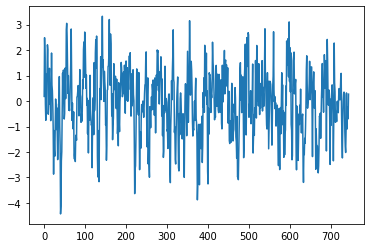

In [41]:
# make the data
n = 744 # hourly for 1 month 


eta = np.random.normal(0, 1.0, n)

rho = [0.60, -0.15]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-24] +eta[i]
     

plt.plot(y)


In [42]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:(n+1)]
hours = [dt.datetime.strptime(hour, "%Y-%m-%d %H:%M") for hour in hours]

In [43]:
df = pd.DataFrame()
df['hours'] = hours
df['y'] = y

In [44]:
df_train = df[0:372]
df_test = df[372:n]

## Prediction Comparison orbit-ml vs. statsmodels

### AR 1, 24

In [45]:
# orbit model and prediction 
mod = ARMA(
        level_first=0,
        estimator='stan-mcmc',
        date_col='hours',
        response_col='y',
        #ma_lags = [1] ,
        ar_lags = [1,24],
    num_warmup=30000,
    num_sample=30000,
)
mod.fit(df_train)
pred = mod.predict(df)
pred = pred.rename(columns={
    'prediction': 'prediction_orbit',
    'prediction_5': 'prediction_5_orbit',
    'prediction_95': 'prediction_95_orbit',
})

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):7500 and samples(per chain):7500.


In [46]:
# stats model and prediction 
y = pd.Series(df_train['y'])
arma_mod = ARIMA(y, order=(1, 0, 0), seasonal_order= (1,0,0,24))
arma_res = arma_mod.fit()
forecast = arma_res.get_forecast(372)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.10)
pred['prediction_5_statsmodel'] = yhat_conf_int['lower y']
pred['prediction_statsmodel'] = yhat
pred['prediction_95_statsmodel'] = yhat_conf_int['upper y']

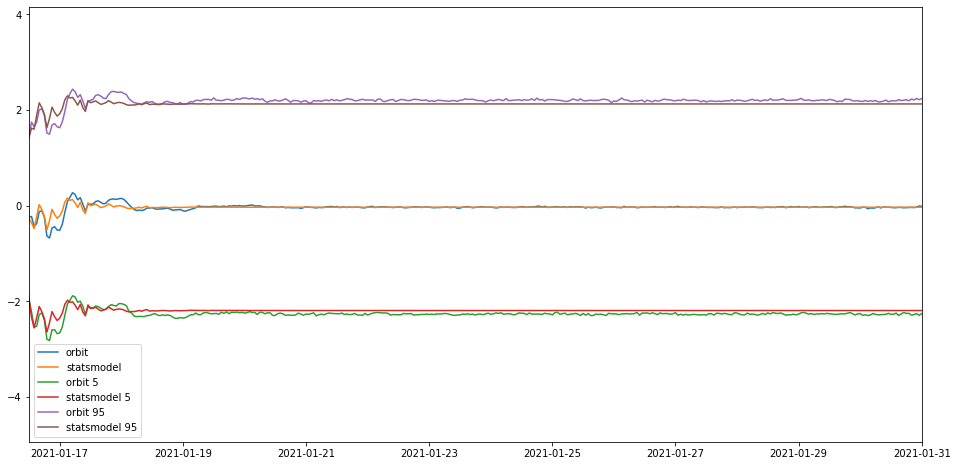

In [47]:
#plot the two predictions 
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#plt.xlim(['2021-01-16 12:00:00', '2021-01-31 12:00:00'])
ax.set_xlim([dt.datetime(2021, 1, 16, 12,0,0), dt.datetime(2021, 1, 31, 0,0,0)])
ax.plot(pred['hours'], pred['prediction_orbit'], label='orbit')
ax.plot(pred['hours'], pred['prediction_statsmodel'], label='statsmodel')
ax.plot(pred['hours'], pred['prediction_5_orbit'], label='orbit 5 ')
ax.plot(pred['hours'], pred['prediction_5_statsmodel'], label='statsmodel 5 ')
ax.plot(pred['hours'], pred['prediction_95_orbit'], label='orbit 95')
ax.plot(pred['hours'], pred['prediction_95_statsmodel'], label='statsmodel 95')
ax.legend()


# Get the Orbit and Statsmodel Parameters

In [48]:
# orbit 
A = mod.get_posterior_samples()
print('mu'+' '+ str(np.percentile(A['mu'], (2.5, 50, 97.5)) ))
print('rho_1'+' '+str(np.percentile(A['rho'][:,0], (2.5, 50, 97.5))))
print('rho_24'+' '+str(np.percentile(A['rho'][:,1], (2.5, 50, 97.5))))
print('sigma'+' '+str(np.percentile(A['obs_sigma'], (2.5, 50, 97.5))))

mu [-0.1207311  -0.01683204  0.08831134]
rho_1 [0.52888392 0.60693295 0.68657151]
rho_24 [-0.22718284 -0.14582276 -0.06354541]
sigma [0.95280828 1.02240395 1.10169289]


In [49]:
# statsmodel
arma_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  372
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood                -536.592
Date:                          Mon, 14 Feb 2022   AIC                           1081.183
Time:                                  16:19:57   BIC                           1096.859
Sample:                                       0   HQIC                          1087.409
                                          - 372                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0327      0.123     -0.265      0.791      -0.274       0.209
ar.L1          0.6166      0.042     14.557      0.000       0.534       0.700
ar.S.L24      -0.1440      0.059     -2.439      0.015      -0.260      -0.028
sigma2         1.0454      0.078     13.344      0.000       0.892       1.199
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 3.12
Prob(Q):                              0.72   Prob(JB):                         0.21
Heteroskedasticity (H):               1.04   Skew:                            -0.21
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""